In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords

# Algorithms
from keras.layers import Flatten,LSTM,Conv1D,Dropout,Bidirectional, GRU, RNN, Concatenate
from keras.utils import plot_model, np_utils
# from keras.utils.vis_utils import model_to_dot
# from keras.models import load_model
# from keras.callbacks import TensorBoard, CSVLogger
# import keras.backend as K

# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# from gensim.models.word2vec import Word2Vec



Using TensorFlow backend.


In [2]:
nltk.download('stopwords')
# nlp = spacy.load('en')

[nltk_data] Downloading package stopwords to /home/akash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# !python -m spacy download en
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Input
from keras.models import Model
from keras.layers import Flatten, Conv1D, RNN, LSTM, GlobalAveragePooling1D, Dense
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [4]:
datapath = './dataset/'


train = pd.read_csv(datapath + 'train.tsv', header=None, index_col=0, delimiter='\t')
val = pd.read_csv(datapath + 'val.tsv', header=None, index_col=0, delimiter='\t')
test = pd.read_csv(datapath + 'test.tsv', header=None, index_col=0, delimiter='\t')

train.head()

train.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job title', 
                 'state info', 'party', 'bt', 'f', 'ht', 'mt', 'pof', 'context', 
                 'justification']

val.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job title', 
                 'state info', 'party', 'bt', 'f', 'ht', 'mt', 'pof', 'context', 
                 'justification']

test.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'job title', 
                 'state info', 'party', 'bt', 'f', 'ht', 'mt', 'pof', 'context', 
                 'justification']


train.drop(['ID','job title', 'state info'], axis=1, inplace=True)
val.drop(['ID','job title', 'state info'], axis=1, inplace=True)
test.drop(['ID','job title', 'state info'], axis=1, inplace=True)
train.drop([2142, 9375], axis=0, inplace=True)

train['justification'] = train['justification'].fillna("no_text")
val['justification'] = val['justification'].fillna("no_text")
test['justification'] = test['justification'].fillna("no_text")

print(train.shape)
print(val.shape)
print(test.shape)

(10238, 12)
(1284, 12)
(1267, 12)


In [5]:
import re

all_data = pd.concat([train, val, test], ignore_index=False)
# print(all_data.head())
print(all_data.shape)
all_data.head()

(12789, 12)


,label,statement,subject,speaker,party,bt,f,ht,mt,pof,context,justification
0,,,,,,,,,,,,
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [6]:
all_statements = []
all_justifications = []


for i in all_data['statement']:
    all_statements.append(i)

for line in all_data['justification']:
    all_justifications.append(line)

print(len(all_statements))
print(len(all_justifications))

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

statements_clean = preprocess_reviews(all_statements)
justifications_clean = preprocess_reviews(all_justifications)

12789
12789


In [7]:
print(all_data.label.unique())
Y_binary = []
# all_data.label.unique().tolist()
for i in all_data['label']:
    if i=='false' or i=='barely-true' or i=='pants-fire':
        Y_binary+=[0]
    else:
        Y_binary+=[1]

Y_six = []

for i in all_data['label']:
    if i =='pants-fire':
        Y_six+=[0]
    elif i=='false':
        Y_six+=[1]
    elif i=='barely-true':
        Y_six+=[2]
    elif i=='half-true':
        Y_six+=[3]
    elif i=='mostly-true':
        Y_six+=[4]
    else:
        Y_six+=[5]
        
# train.label.unique()
print(len(Y_binary), len(Y_six))

['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']
12789 12789


In [8]:
X_train = statements_clean[:train.shape[0]]
X_val = statements_clean[train.shape[0]:train.shape[0]+val.shape[0]]
X_test = statements_clean[train.shape[0]+val.shape[0]:]
print(len(X_train), len(X_val), len(X_test))

X_trainj = justifications_clean[:train.shape[0]]
X_valj = justifications_clean[train.shape[0]:train.shape[0]+val.shape[0]]
X_testj = justifications_clean[train.shape[0]+val.shape[0]:]

Y_train_bi = Y_binary[:train.shape[0]]
Y_val_bi = Y_binary[train.shape[0]:train.shape[0]+val.shape[0]]
Y_test_bi = Y_binary[train.shape[0]+val.shape[0]:]

Y_train_six = Y_six[:train.shape[0]]
Y_val_six = Y_six[train.shape[0]:train.shape[0]+val.shape[0]]
Y_test_six = Y_six[train.shape[0]+val.shape[0]:]

10238 1284 1267


In [9]:
freq_words_state=4000

tokenizer_state = Tokenizer(num_words=freq_words_state)
tokenizer_state.fit_on_texts(X_train)

X_train = tokenizer_state.texts_to_sequences(X_train)
X_val = tokenizer_state.texts_to_sequences(X_val)
X_test = tokenizer_state.texts_to_sequences(X_test)

In [10]:
freq_words_justify=6000

tokenizer_justify = Tokenizer(num_words=freq_words_justify)
tokenizer_justify.fit_on_texts(X_trainj)

X_trainj = tokenizer_justify.texts_to_sequences(X_trainj)
X_valj = tokenizer_justify.texts_to_sequences(X_valj)
X_testj = tokenizer_justify.texts_to_sequences(X_testj)

In [11]:
vocab_size_state = len(tokenizer_state.word_index) + 1
print(vocab_size_state)
maxlen_s = 100

X_train = pad_sequences(X_train, maxlen=maxlen_s, padding='post')
X_val = pad_sequences(X_val, maxlen=maxlen_s, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen_s, padding='post')

11762


In [12]:
print(X_train[3])

[  31   44  252  280   10  627    4  628  376  437  380 3940    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [13]:
vocab_size_justify = len(tokenizer_justify.word_index) + 1
print(vocab_size_justify)
maxlen_j = 150

X_trainj = pad_sequences(X_trainj, maxlen=maxlen_j, padding='post')
X_valj = pad_sequences(X_valj, maxlen=maxlen_j, padding='post')
X_testj = pad_sequences(X_testj, maxlen=maxlen_j, padding='post')

22915


In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
embedding_matrix_s = zeros((vocab_size_state, 100))
for word, index in tokenizer_state.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_s[index] = embedding_vector
    
print(embedding_matrix_s.shape)

(11762, 100)


In [16]:
embedding_matrix_j = zeros((vocab_size_justify, 100))
for word, index in tokenizer_justify.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_j[index] = embedding_vector
    
print(embedding_matrix_j.shape)

(22915, 100)


In [17]:
embedding_layer_s = Embedding(vocab_size_state, 100, weights=[embedding_matrix_s],
                              input_length=maxlen_s , trainable=False)
print(embedding_layer_s)

embedding_layer_j = Embedding(vocab_size_justify, 100, weights=[embedding_matrix_j],
                              input_length=maxlen_j , trainable=False)
print(embedding_layer_j)

W0805 13:48:31.552715 140442425616192 deprecation_wrapper.py:119] From /home/akash/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [18]:
seq_input = Input(shape=(maxlen_s, ), dtype='int32')
x = embedding_layer_s(seq_input)
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=seq_input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

W0805 13:48:31.644662 140442425616192 deprecation_wrapper.py:119] From /home/akash/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 13:48:31.648791 140442425616192 deprecation_wrapper.py:119] From /home/akash/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 13:48:31.662241 140442425616192 deprecation_wrapper.py:119] From /home/akash/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 13:48:31.663477 140442425616192 deprecation_wrapper.py:119] From /home/akash/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          1176200   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 1,186,201
Trainable params: 10,001
Non-trainable params: 1,176,200
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, Y_train_bi, batch_size=128, epochs=5, verbose=1,
                   validation_data=(X_val, Y_val_bi))

Train on 10238 samples, validate on 1284 samples
Epoch 1/5
10238/10238 [==============================] - 1s 65us/step - loss: 0.6771 - acc: 0.5766 - val_loss: 0.6696 - val_acc: 0.5654
Epoch 2/5
10238/10238 [==============================] - 0s 23us/step - loss: 0.6476 - acc: 0.6190 - val_loss: 0.6791 - val_acc: 0.5693
Epoch 3/5
10238/10238 [==============================] - 0s 21us/step - loss: 0.6268 - acc: 0.6454 - val_loss: 0.6712 - val_acc: 0.5864
Epoch 4/5
10238/10238 [==============================] - 0s 22us/step - loss: 0.6124 - acc: 0.6611 - val_loss: 0.6798 - val_acc: 0.5779
Epoch 5/5
10238/10238 [==============================] - 0s 25us/step - loss: 0.6040 - acc: 0.6728 - val_loss: 0.6730 - val_acc: 0.5974


In [20]:
loss,acc = model.evaluate(X_val, Y_val_bi, verbose=1)
print(acc)
loss,acc = model.evaluate(X_test, Y_test_bi, verbose=1)
print(acc)

1284/1284 [==============================] - 0s 25us/step
0.5973520249221184
1267/1267 [==============================] - 0s 10us/step
0.5793212313019769


In [21]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


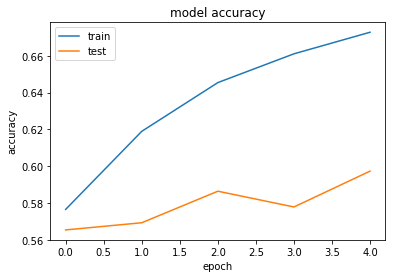

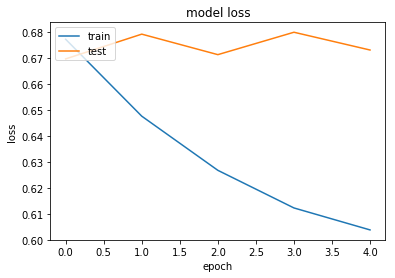

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [23]:
seq_input = Input(shape=(maxlen_s, ), dtype='int32')
x = embedding_layer_s(seq_input)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=seq_input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          1176200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,240,457
Trainable params: 64,257
Non-trainable params: 1,176,200
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, Y_train_bi, batch_size=128, epochs=5, verbose=1,
                   validation_data=(X_val, Y_val_bi))

loss, acc= model.evaluate(X_train, Y_train_bi, verbose=1)
print(acc)
loss, acc = model.evaluate(X_test, Y_test_bi, verbose=1)
print(acc)

Train on 10238 samples, validate on 1284 samples
Epoch 1/5
10238/10238 [==============================] - 3s 323us/step - loss: 0.6757 - acc: 0.5788 - val_loss: 0.6781 - val_acc: 0.5763
Epoch 2/5
10238/10238 [==============================] - 2s 237us/step - loss: 0.6085 - acc: 0.6767 - val_loss: 0.6611 - val_acc: 0.6059
Epoch 3/5
10238/10238 [==============================] - 2s 227us/step - loss: 0.5663 - acc: 0.7265 - val_loss: 0.6571 - val_acc: 0.6121
Epoch 4/5
10238/10238 [==============================] - 2s 227us/step - loss: 0.5205 - acc: 0.7731 - val_loss: 0.6703 - val_acc: 0.6051
Epoch 5/5
10238/10238 [==============================] - 1s 101us/step
0.8700918148308672
1267/1267 [==============================] - 0s 112us/step
0.601420678815789


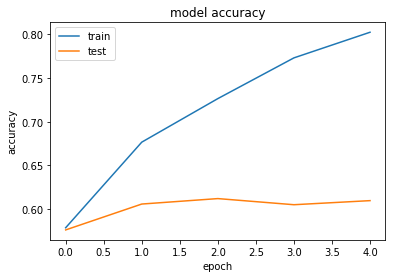

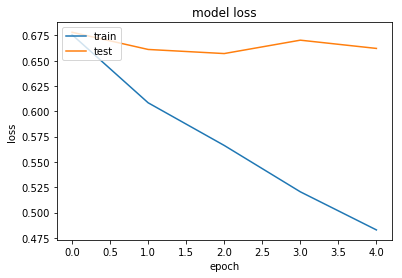

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [26]:
seq_input = Input(shape=(maxlen_s, ), dtype='int32')
x = embedding_layer_s(seq_input)
x = LSTM(128)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=seq_input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          1176200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,293,577
Trainable params: 117,377
Non-trainable params: 1,176,200
_________________________________________________________________
None


In [27]:
history = model.fit(X_train, Y_train_bi, batch_size=128, epochs=5, verbose=1,
             validation_data=(X_val, Y_val_bi))

loss, acc = model.evaluate(X_val, Y_val_bi, verbose=1)
print(acc)

loss, acc = model.evaluate(X_test, Y_test_bi, verbose=1)
print(acc)

Train on 10238 samples, validate on 1284 samples
Epoch 1/5
10238/10238 [==============================] - 19s 2ms/step - loss: 0.6866 - acc: 0.5581 - val_loss: 0.6928 - val_acc: 0.5202
Epoch 2/5
10238/10238 [==============================] - 16s 2ms/step - loss: 0.6855 - acc: 0.5618 - val_loss: 0.6962 - val_acc: 0.5202
Epoch 3/5
10238/10238 [==============================] - 16s 2ms/step - loss: 0.6855 - acc: 0.5619 - val_loss: 0.6937 - val_acc: 0.5202
Epoch 4/5
10238/10238 [==============================] - 16s 2ms/step - loss: 0.6858 - acc: 0.5619 - val_loss: 0.6943 - val_acc: 0.5202
Epoch 5/5
1284/1284 [==============================] - 1s 913us/step
0.5202492211838006
1267/1267 [==============================] - 1s 902us/step
0.5635359115316441


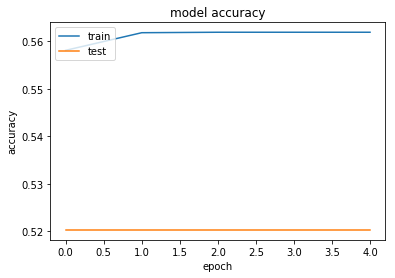

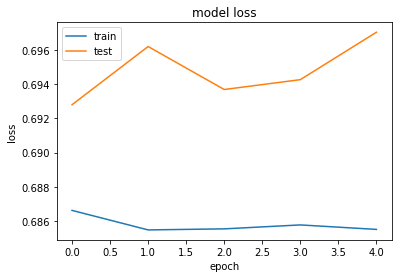

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [29]:
seq_input1 = Input(shape=(maxlen_s, ), dtype='int32')
seq_input2 = Input(shape=(maxlen_j, ), dtype='int32')

emb_s = embedding_layer_s(seq_input1)
emb_j = embedding_layer_j(seq_input2)

gru11 = Bidirectional(GRU(128, return_sequences=True), merge_mode='concat')(emb_s)
gru12 = Bidirectional(GRU(64, return_sequences=False), merge_mode='concat')(gru11)

gru21 = Bidirectional(GRU(128, return_sequences=True), merge_mode='concat')(emb_j)
gru22 = Bidirectional(GRU(64, return_sequences=False), merge_mode='concat')(gru21)

merge1 = Concatenate(axis=-1)([gru12, gru22])

dense1 = Dense(1, activation='sigmoid')(merge1)

model = Model(inputs=[seq_input1, seq_input2], outputs=dense1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     1176200     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 150, 100)     2291500     input_5[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [30]:
plot_model(model, to_file='BiLSTM.png')

In [31]:
# history = model.fit([X_train, X_trainj], Y_train_bi, batch_size=128, epochs=5, verbose=1,
#              validation_data=(X_val, Y_val_bi))

# loss, acc = model.evaluate([X_val, X_valj], Y_val_bi, verbose=1)
# print(acc)

# loss, acc = model.evaluate([X_test, X_testj], Y_test_bi, verbose=1)
# print(acc)

In [32]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

In [33]:
# Six classes

seq_input = Input(shape=(maxlen_s, ), dtype='int32')
x = embedding_layer_s(seq_input)
x = Flatten()(x)
x = Dense(6, activation='sigmoid')(x)

model = Model(inputs=seq_input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          1176200   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 60006     
Total params: 1,236,206
Trainable params: 60,006
Non-trainable params: 1,176,200
_________________________________________________________________
None


In [34]:
Y_train_six = np.asarray(Y_train_six)
Y_val_six = np.asarray(Y_val_six)
Y_test_six = np.asarray(Y_test_six)

Y_train_six = np_utils.to_categorical(Y_train_six, 6)
Y_val_six = np_utils.to_categorical(Y_val_six, 6)
Y_test_six = np_utils.to_categorical(Y_test_six, 6)
print(Y_train_six.shape, Y_val_six.shape, Y_test_six.shape)

(10238, 6) (1284, 6) (1267, 6)


In [35]:
history = model.fit(X_train, Y_train_six, batch_size=128, epochs=5, verbose=1,
                   validation_data=(X_val, Y_val_six))

loss,acc = model.evaluate(X_val, Y_val_six, verbose=1)
print(acc)
loss,acc = model.evaluate(X_test, Y_test_six, verbose=1)
print(acc)

Train on 10238 samples, validate on 1284 samples
Epoch 1/5
10238/10238 [==============================] - 1s 127us/step - loss: 0.4624 - acc: 0.8280 - val_loss: 0.4443 - val_acc: 0.8328
Epoch 2/5
10238/10238 [==============================] - 0s 36us/step - loss: 0.4281 - acc: 0.8339 - val_loss: 0.4456 - val_acc: 0.8327
Epoch 3/5
10238/10238 [==============================] - 0s 35us/step - loss: 0.4138 - acc: 0.8353 - val_loss: 0.4440 - val_acc: 0.8314
Epoch 4/5
10238/10238 [==============================] - 0s 38us/step - loss: 0.4034 - acc: 0.8368 - val_loss: 0.4471 - val_acc: 0.8298
Epoch 5/5
1284/1284 [==============================] - 0s 23us/step
0.8300882993828842
1267/1267 [==============================] - 0s 35us/step
0.8300447499742636


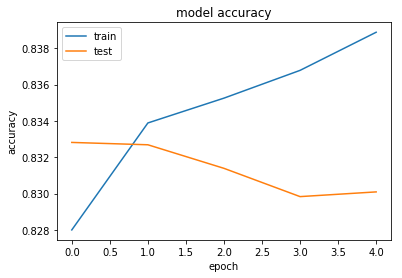

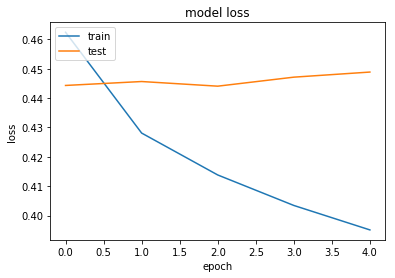

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [39]:
seq_input1 = Input(shape=(maxlen_s, ), dtype='int32')
seq_input2 = Input(shape=(maxlen_j, ), dtype='int32')

emb_s = embedding_layer_s(seq_input1)
emb_j = embedding_layer_j(seq_input2)

c1 = Conv1D(128, 5, activation='relu')(emb_s)
c2 = Conv1D(128, 5, activation='relu')(emb_j)


g1 = GlobalMaxPooling1D()(c1)
g2 = GlobalMaxPooling1D()(c2)

x = Concatenate(axis=-1)([g1, g2])
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[seq_input1, seq_input2], outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     1176200     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 150, 100)     2291500     input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (

In [40]:
history = model.fit([X_train, X_trainj], Y_train_bi, batch_size=128, epochs=5, verbose=1,
                   validation_data=([X_val, X_valj], Y_val_bi))

loss, acc= model.evaluate([X_train, X_trainj], Y_train_bi, verbose=1)
print(acc)
loss, acc = model.evaluate([X_test, X_testj], Y_test_bi, verbose=1)
print(acc)

Train on 10238 samples, validate on 1284 samples
Epoch 1/5
10238/10238 [==============================] - 7s 650us/step - loss: 0.6838 - acc: 0.5717 - val_loss: 0.6685 - val_acc: 0.5849
Epoch 2/5
10238/10238 [==============================] - 6s 545us/step - loss: 0.5989 - acc: 0.6850 - val_loss: 0.6741 - val_acc: 0.5864
Epoch 3/5
10238/10238 [==============================] - 6s 543us/step - loss: 0.5379 - acc: 0.7641 - val_loss: 0.7020 - val_acc: 0.5771
Epoch 4/5
10238/10238 [==============================] - 6s 543us/step - loss: 0.4810 - acc: 0.8166 - val_loss: 0.6509 - val_acc: 0.6238
Epoch 5/5
10238/10238 [==============================] - 2s 205us/step
0.8777104903417864
1267/1267 [==============================] - 0s 214us/step
0.6037884767636974


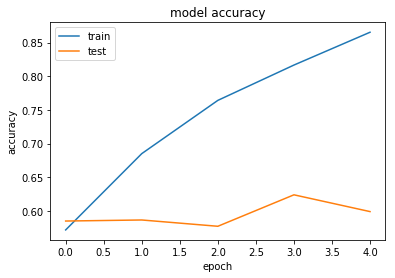

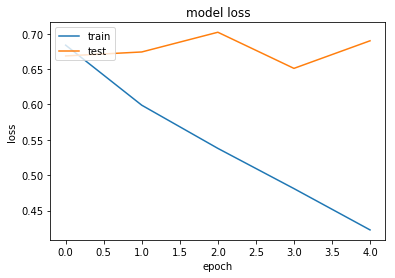

In [41]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()